In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import os
import re

In [11]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

In [12]:
directory = "team_battery"

# Regex to capture the float X from filenames like cal_10_(X).mca
pattern = re.compile(r"fe_\d+\_(\d*)\.mca")

# Temporary storage for (x_value, data_list)
temp_storage = []

for filename in os.listdir(directory):
    match = pattern.search(filename)
    if match:
        x_value = float(match.group(1))
        file_path = os.path.join(directory, filename)
        data = extract_mca_data(file_path)
        temp_storage.append((x_value, data))

# Sort by x_value
temp_storage.sort(key=lambda item: item[0])

# Separate into two lists
file_labels = [item[0] for item in temp_storage]
all_data_lists = [item[1] for item in temp_storage]

print(f"Loaded {len(all_data_lists)} files in ascending order of X.")
for i, data_list in enumerate(all_data_lists):
    print(f"File {i+1} (X={file_labels[i]}): {len(data_list)} points")

Loaded 22 files in ascending order of X.
File 1 (X=1388.0): 1024 points
File 2 (X=1448.0): 1024 points
File 3 (X=1508.0): 1024 points
File 4 (X=1568.0): 1024 points
File 5 (X=1568.0): 1024 points
File 6 (X=1628.0): 1024 points
File 7 (X=1688.0): 1024 points
File 8 (X=1748.0): 1024 points
File 9 (X=1748.0): 1024 points
File 10 (X=1808.0): 1024 points
File 11 (X=1868.0): 1024 points
File 12 (X=1928.0): 1024 points
File 13 (X=1928.0): 1024 points
File 14 (X=1988.0): 1024 points
File 15 (X=2048.0): 1024 points
File 16 (X=2048.0): 1024 points
File 17 (X=2108.0): 1024 points
File 18 (X=2168.0): 1024 points
File 19 (X=2168.0): 1024 points
File 20 (X=2228.0): 1024 points
File 21 (X=2288.0): 1024 points
File 22 (X=2348.0): 1024 points


In [13]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))

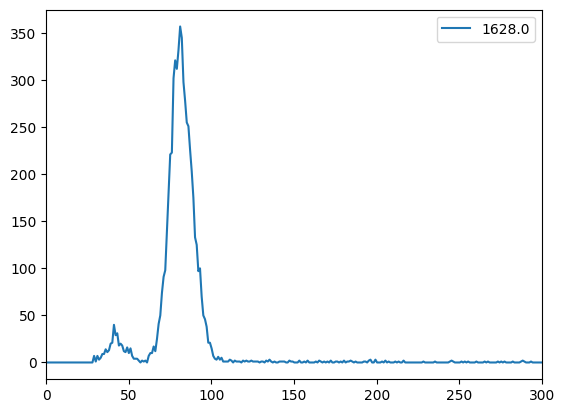

In [14]:
from scipy.signal import argrelextrema
index=5
# local_max=argrelextrema(np.array(all_data_lists[index]),np.greater)
# print(local_max)
channel_no=np.linspace(0,len(all_data_lists[index]),1024)
fig, ax = plt.subplots()
ax.plot(channel_no,all_data_lists[index],label=file_labels[index])
ax.legend()
plt.xlim(0,300)
plt.show()


In [15]:
def curve_fit(function, channel, data_list,range,init_guess):
    mu, cov=sci.curve_fit(function,channel[range[0]:range[1]],data_list[index][range[0]:range[1]],p0=init_guess)
    gauss=gaussian(channel,*mu)
    return gauss

In [16]:
range_list=[60,98]
init_guess=[350,70,1]
fit_gaussian=curve_fit(gaussian,channel_no,all_data_lists,range_list,init_guess)

In [17]:
def hist_generator(index,data_list,label_list):
    plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])  
    # plt.xlim(0,100)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))

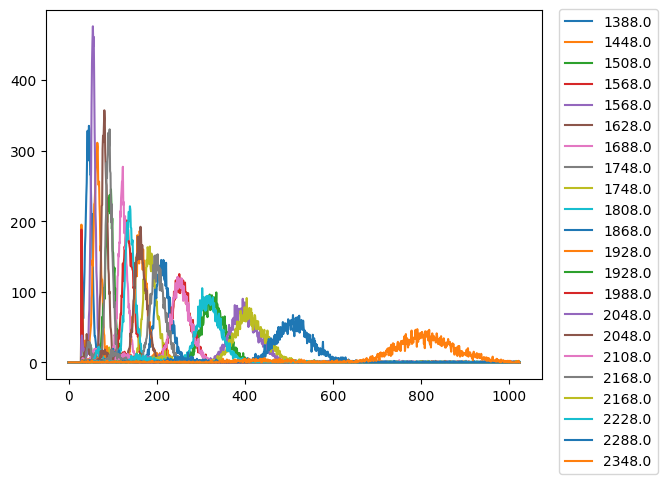

In [18]:
for i in range(0,len(all_data_lists)):
    hist_generator(i,all_data_lists,file_labels)